In [9]:
# Install required packages
!pip install pyspark matplotlib seaborn plotly -q

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os

# Set style
plt.style.use('dark_background')
sns.set_palette('husl')

print("✅ Libraries imported")

✅ Libraries imported


In [10]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/NetworkIDS"
MODEL_DIR = f"{BASE_DIR}/output/models"
VIZ_DIR = f"{BASE_DIR}/output/visualizations"
os.makedirs(VIZ_DIR, exist_ok=True)

print(f"📂 Models: {MODEL_DIR}")
print(f"📂 Visualizations will be saved to: {VIZ_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Models: /content/drive/MyDrive/NetworkIDS/output/models
📂 Visualizations will be saved to: /content/drive/MyDrive/NetworkIDS/output/visualizations


In [11]:
# Load training results
results_path = f"{MODEL_DIR}/training_results.json"

with open(results_path, 'r') as f:
    results = json.load(f)

print("📊 Training Results Loaded:")
print(json.dumps(results, indent=2))

📊 Training Results Loaded:
{
  "rf_binary": {
    "model": "Random Forest",
    "task": "Binary Classification",
    "auc_roc": 0.9757226703241804,
    "auc_pr": 0.9413921390274911,
    "accuracy": 0.9714982169293263,
    "f1": 0.9719226757011122,
    "precision": 0.9727990758929528,
    "recall": 0.9714982169293263
  },
  "gbt_binary": {
    "model": "Gradient Boosted Trees",
    "task": "Binary Classification",
    "auc_roc": 0.9852229221145318,
    "auc_pr": 0.9712505304645876,
    "accuracy": 0.9817280835454301,
    "f1": 0.9817859464738505,
    "precision": 0.9818642427192529,
    "recall": 0.98172808354543
  },
  "rf_multiclass": {
    "model": "Random Forest",
    "task": "Multi-class Classification (9 classes)",
    "accuracy": 0.987,
    "f1": 0.9858,
    "precision": 0.9851,
    "recall": 0.987
  },
  "train_size": 2191961,
  "test_size": 548492,
  "total_records": 2740453
}


## 1. Model Performance Comparison

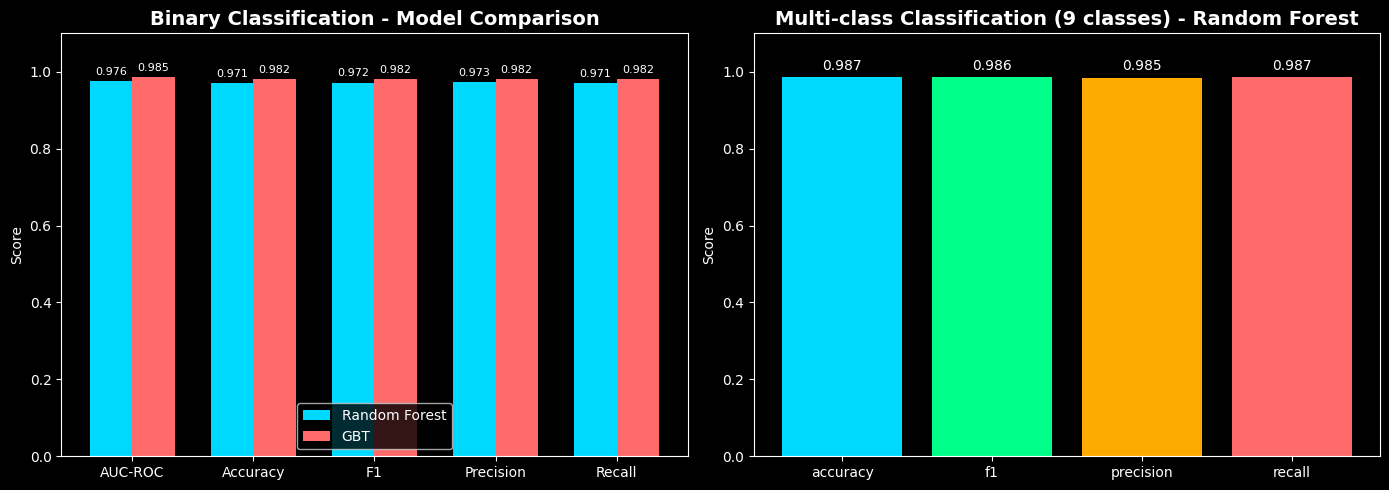

✅ Saved: /content/drive/MyDrive/NetworkIDS/output/visualizations/model_comparison.png


In [12]:
# Binary Classification Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics for binary models
models = ['Random Forest', 'GBT']
metrics = ['auc_roc', 'accuracy', 'f1', 'precision', 'recall']

rf_binary = results['rf_binary']
gbt_binary = results['gbt_binary']

# Bar chart comparison
x = np.arange(len(metrics))
width = 0.35

rf_values = [rf_binary.get(m, 0) for m in metrics]
gbt_values = [gbt_binary.get(m, 0) for m in metrics]

bars1 = axes[0].bar(x - width/2, rf_values, width, label='Random Forest', color='#00d9ff')
bars2 = axes[0].bar(x + width/2, gbt_values, width, label='GBT', color='#ff6b6b')

axes[0].set_ylabel('Score')
axes[0].set_title('Binary Classification - Model Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['AUC-ROC', 'Accuracy', 'F1', 'Precision', 'Recall'])
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)


rf_multi = results['rf_multiclass']
multi_metrics = ['accuracy', 'f1', 'precision', 'recall']
multi_values = [rf_multi.get(m, 0) for m in multi_metrics]

# Simple bar for multiclass
colors = ['#00d9ff', '#00ff88', '#ffaa00', '#ff6b6b']
bars = axes[1].bar(multi_metrics, multi_values, color=colors)
axes[1].set_ylabel('Score')
axes[1].set_title('Multi-class Classification (9 classes) - Random Forest', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.1)

for bar, val in zip(bars, multi_values):
    axes[1].annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, val),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(f"{VIZ_DIR}/model_comparison.png", dpi=300, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print(f"✅ Saved: {VIZ_DIR}/model_comparison.png")

## 2. Generate Confusion Matrix (Requires Spark)

In [13]:
# Create Spark session to load models and generate confusion matrix
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.classification import RandomForestClassificationModel
import gc

gc.collect()

spark = SparkSession.builder \
    .appName("NIDS-Visualization") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .master("local[2]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
print("✅ Spark session created")

✅ Spark session created


In [14]:
# Load data and model
DATA_PATH = f"{BASE_DIR}/output/parquet/cicids_merged_harmonized"

df = spark.read.parquet(DATA_PATH)
df_train = df.select('features_scaled', 'binary_label', 'unified_label', 'sample_weight', 'multiclass_weight')

# Get test sample
_, test_df = df_train.randomSplit([0.8, 0.2], seed=42)
test_sampled = test_df.sample(fraction=0.1, seed=42).cache()
print(f"✅ Test sample: {test_sampled.count():,} records")

✅ Test sample: 365,686 records


In [17]:

rf_multi_model = RandomForestClassificationModel.load(f"{MODEL_DIR}/rf_multiclass_improved")

predictions = rf_multi_model.transform(test_sampled)

# Convert to pandas for visualization
pred_pdf = predictions.select('unified_label', 'prediction').toPandas()
print(f"✅ Predictions generated: {len(pred_pdf):,} records")

✅ Predictions generated: 365,686 records


In [18]:
# Attack type mapping
ATTACK_TYPES = {
    0: "Benign",
    1: "DoS",
    2: "DDoS",
    3: "PortScan",
    4: "BruteForce",
    5: "WebAttack",
    6: "Infiltration",
    7: "Botnet",
    8: "Heartbleed",
}

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

y_true = pred_pdf['unified_label'].astype(int)
y_pred = pred_pdf['prediction'].astype(int)

# Get unique labels
labels = sorted(set(y_true) | set(y_pred))
label_names = [ATTACK_TYPES.get(l, f"Class {l}") for l in labels]

cm = confusion_matrix(y_true, y_pred, labels=labels)

# Normalize
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)

print("✅ Confusion matrix generated")

✅ Confusion matrix generated


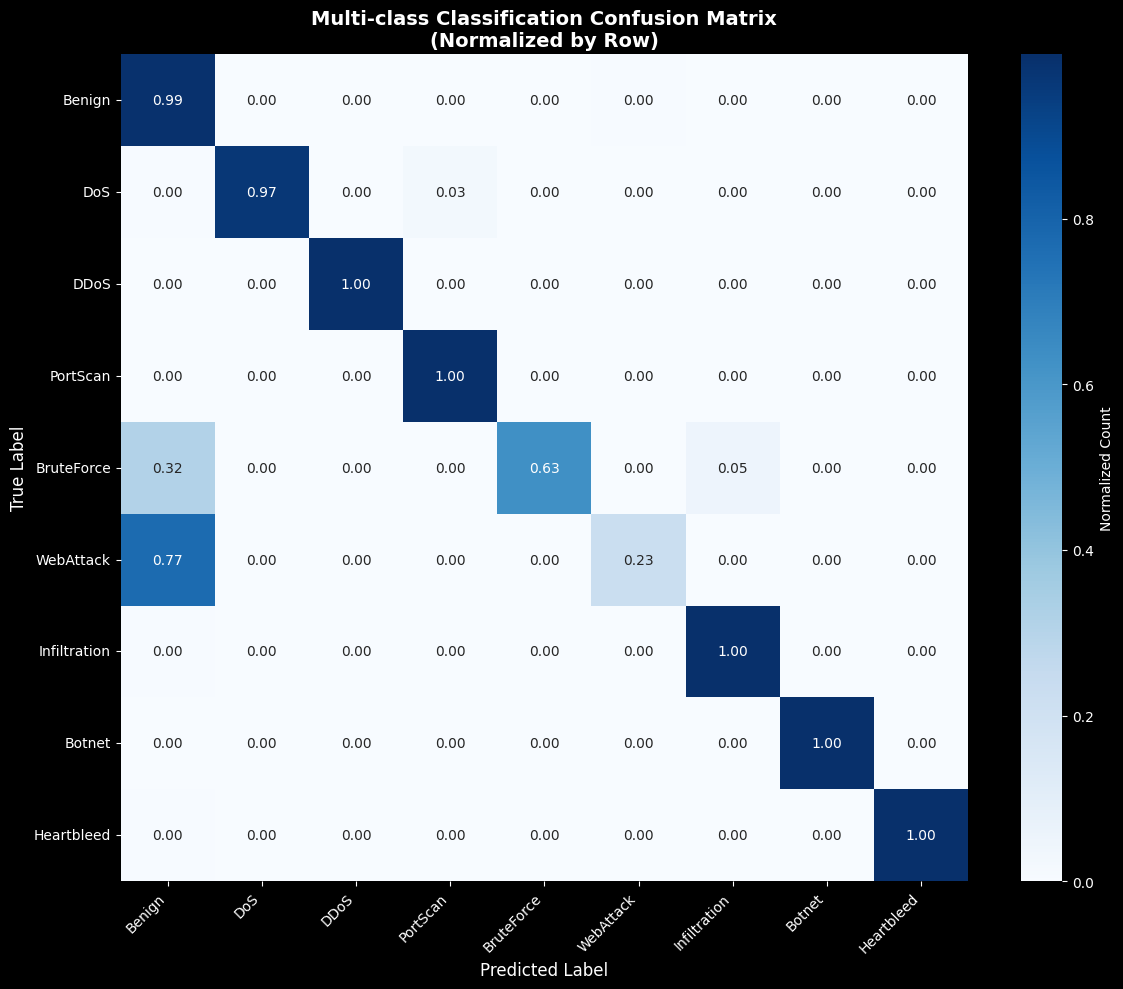

✅ Saved: /content/drive/MyDrive/NetworkIDS/output/visualizations/confusion_matrix_multiclass.png


In [19]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            ax=ax, cbar_kws={'label': 'Normalized Count'})

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Multi-class Classification Confusion Matrix\n(Normalized by Row)', fontsize=14, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(f"{VIZ_DIR}/confusion_matrix_multiclass.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {VIZ_DIR}/confusion_matrix_multiclass.png")

In [20]:
# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99    310062
         DoS       1.00      0.97      0.98     14010
        DDoS       0.99      1.00      1.00     14272
    PortScan       0.90      1.00      0.95      3245
  BruteForce       0.11      0.63      0.18        19
   WebAttack       0.37      0.23      0.28      3251
Infiltration       0.97      1.00      0.98      5670
      Botnet       0.99      1.00      0.99      1757
  Heartbleed       1.00      1.00      1.00     13400

    accuracy                           0.99    365686
   macro avg       0.81      0.87      0.82    365686
weighted avg       0.99      0.99      0.99    365686



## 3. Feature Importance Visualization

In [21]:
# Get feature importances
importances = rf_multi_model.featureImportances.toArray()

# Feature names (from your training data)
FEATURE_NAMES = [
    "Destination Port", "Flow Duration", "Total Fwd Packets", "Total Backward Packets",
    "Total Length of Fwd Packets", "Total Length of Bwd Packets", "Fwd Packet Length Max",
    "Fwd Packet Length Min", "Fwd Packet Length Mean", "Fwd Packet Length Std",
    "Bwd Packet Length Max", "Bwd Packet Length Min", "Bwd Packet Length Mean",
    "Bwd Packet Length Std", "Flow Bytes/s", "Flow Packets/s", "Flow IAT Mean",
    "Flow IAT Std", "Flow IAT Max", "Flow IAT Min", "Fwd IAT Total", "Fwd IAT Mean",
    "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min", "Bwd IAT Total", "Bwd IAT Mean",
    "Bwd IAT Std", "Bwd IAT Max", "Bwd IAT Min", "Fwd PSH Flags", "Bwd PSH Flags",
    "Fwd URG Flags", "Bwd URG Flags", "Fwd Header Length", "Bwd Header Length",
    "Fwd Packets/s", "Bwd Packets/s", "Min Packet Length", "Max Packet Length",
    "Packet Length Mean", "Packet Length Std", "Packet Length Variance", "FIN Flag Count",
    "SYN Flag Count", "RST Flag Count", "PSH Flag Count", "ACK Flag Count",
    "URG Flag Count", "CWE Flag Count", "ECE Flag Count", "Down/Up Ratio",
    "Average Packet Size", "Avg Fwd Segment Size", "Avg Bwd Segment Size"
]

# Create dataframe
if len(FEATURE_NAMES) <= len(importances):
    feature_imp_df = pd.DataFrame({
        'feature': FEATURE_NAMES[:len(importances)],
        'importance': importances[:len(FEATURE_NAMES)]
    }).sort_values('importance', ascending=False)
else:
    feature_imp_df = pd.DataFrame({
        'feature': [f"Feature {i}" for i in range(len(importances))],
        'importance': importances
    }).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_imp_df.head(15).to_string(index=False))

Top 15 Most Important Features:
                    feature  importance
           Destination Port    0.064355
          Bwd Header Length    0.043737
              Fwd IAT Total    0.033832
               Flow IAT Std    0.028499
               Fwd IAT Mean    0.027814
              Bwd IAT Total    0.026988
Total Length of Bwd Packets    0.026383
      Bwd Packet Length Std    0.025043
                Fwd IAT Min    0.023569
          Total Fwd Packets    0.023151
                Fwd IAT Std    0.022764
      Fwd Packet Length Min    0.021874
              Flow IAT Mean    0.019685
          Min Packet Length    0.019568
      Fwd Packet Length Max    0.019436


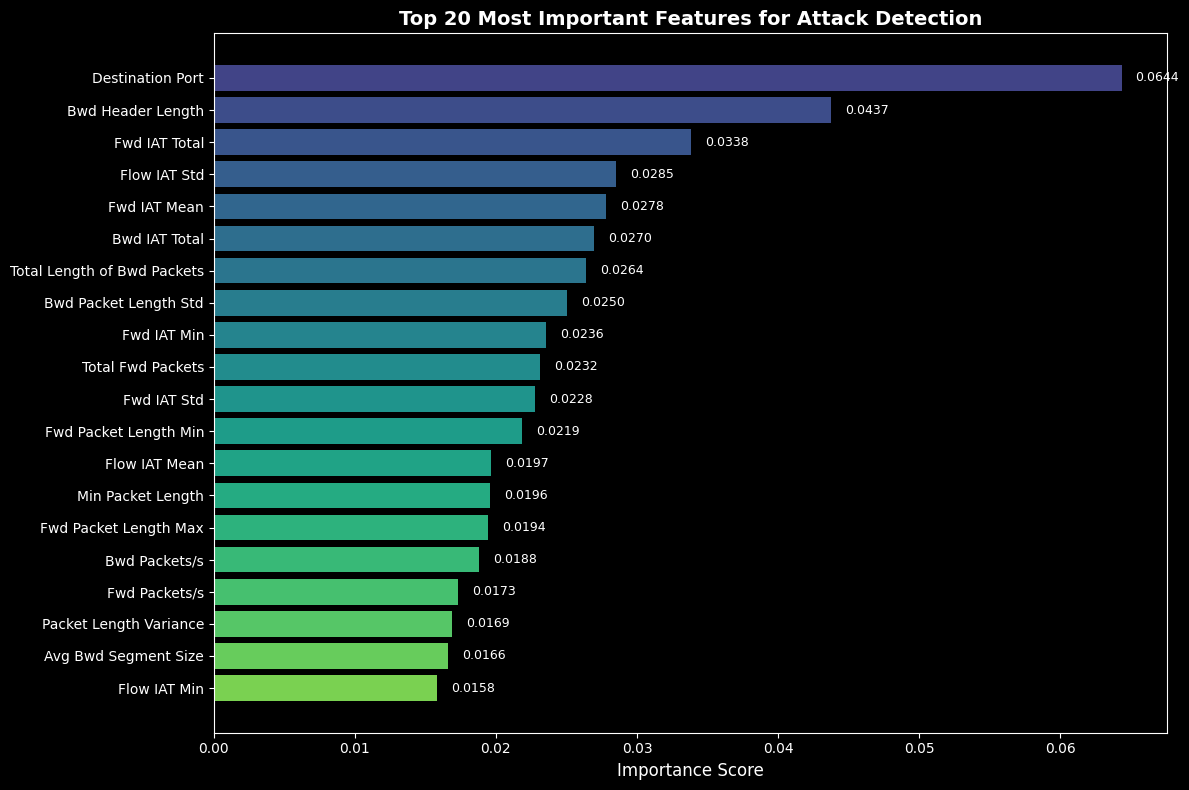

✅ Saved: /content/drive/MyDrive/NetworkIDS/output/visualizations/feature_importance.png


In [22]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 8))

top_features = feature_imp_df.head(20)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_features)))
bars = ax.barh(range(len(top_features)), top_features['importance'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 20 Most Important Features for Attack Detection', fontsize=14, fontweight='bold')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_features['importance'])):
    ax.text(val + 0.001, i, f'{val:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f"{VIZ_DIR}/feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {VIZ_DIR}/feature_importance.png")

## 4. Attack Distribution Visualization

In [23]:
# Get attack distribution from test data
attack_dist = test_sampled.groupBy('unified_label').count().toPandas()
attack_dist['attack_type'] = attack_dist['unified_label'].map(ATTACK_TYPES)
attack_dist = attack_dist.sort_values('count', ascending=False)

print("Attack Distribution:")
print(attack_dist.to_string(index=False))

Attack Distribution:
 unified_label  count  attack_type
             0 310062       Benign
             2  14272         DDoS
             1  14010          DoS
             8  13400   Heartbleed
             6   5670 Infiltration
             5   3251    WebAttack
             3   3245     PortScan
             7   1757       Botnet
             4     19   BruteForce


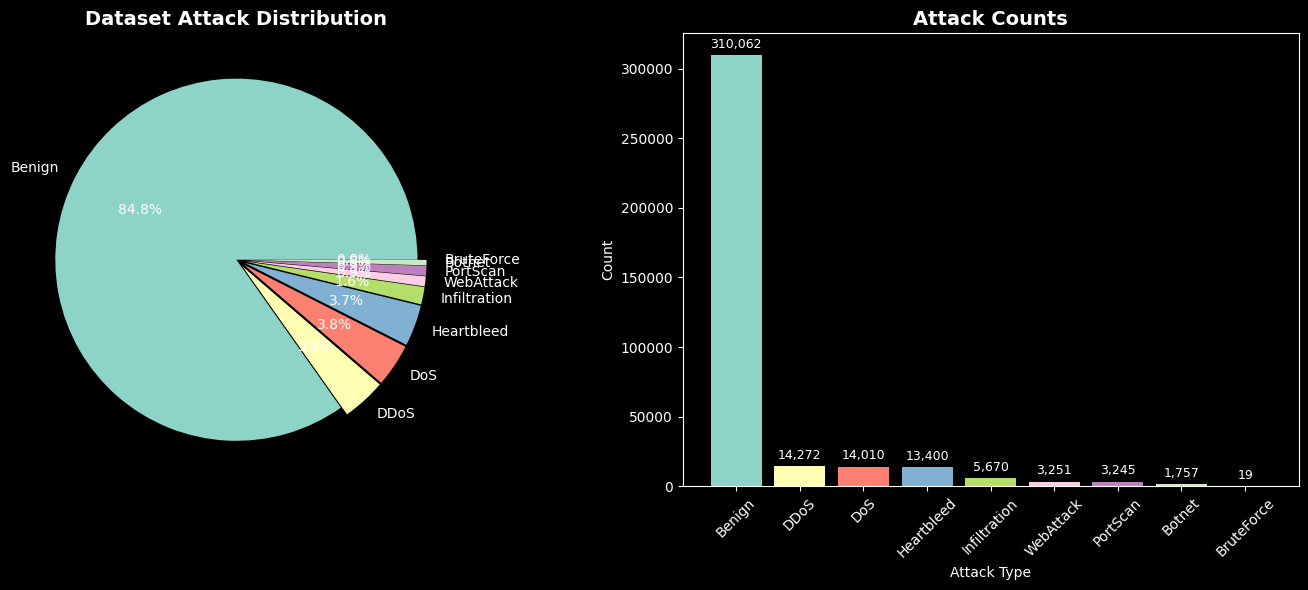

✅ Saved: /content/drive/MyDrive/NetworkIDS/output/visualizations/attack_distribution.png


In [24]:
# Pie chart for attack distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
colors = plt.cm.Set3(np.linspace(0, 1, len(attack_dist)))
wedges, texts, autotexts = axes[0].pie(
    attack_dist['count'],
    labels=attack_dist['attack_type'],
    autopct='%1.1f%%',
    colors=colors,
    explode=[0.05 if x != 'Benign' else 0 for x in attack_dist['attack_type']]
)
axes[0].set_title('Dataset Attack Distribution', fontsize=14, fontweight='bold')

# Bar chart
bars = axes[1].bar(attack_dist['attack_type'], attack_dist['count'], color=colors)
axes[1].set_xlabel('Attack Type')
axes[1].set_ylabel('Count')
axes[1].set_title('Attack Counts', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1].annotate(f'{int(height):,}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f"{VIZ_DIR}/attack_distribution.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {VIZ_DIR}/attack_distribution.png")

## 5. Per-Class Recall (Detection Rate)

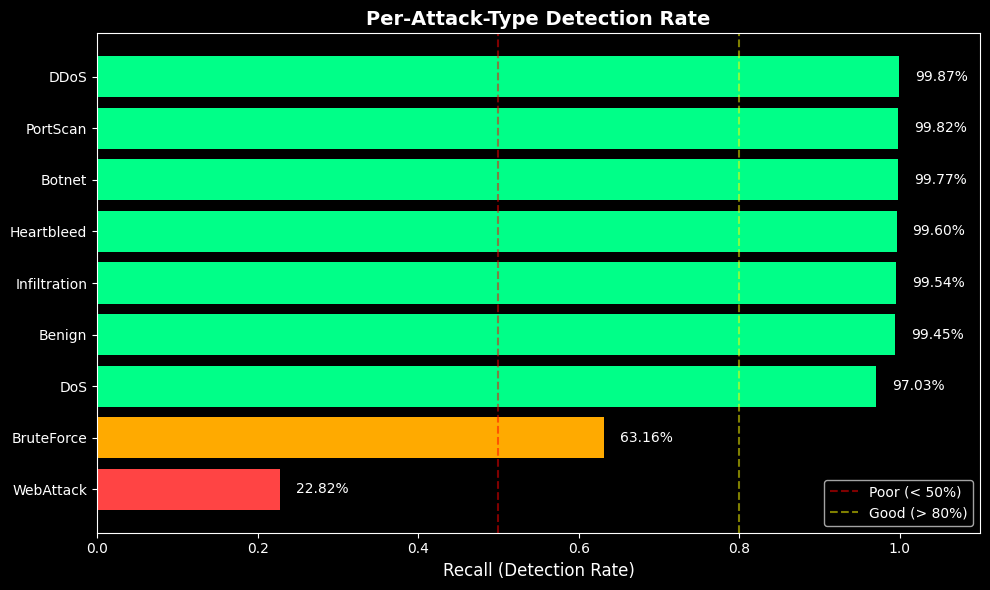

✅ Saved: /content/drive/MyDrive/NetworkIDS/output/visualizations/per_class_recall.png


In [25]:
# Calculate per-class recall
from sklearn.metrics import recall_score

per_class_recall = {}
for label in labels:
    y_true_binary = (y_true == label).astype(int)
    y_pred_binary = (y_pred == label).astype(int)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    per_class_recall[ATTACK_TYPES.get(label, f"Class {label}")] = recall

recall_df = pd.DataFrame(list(per_class_recall.items()), columns=['Attack Type', 'Recall'])
recall_df = recall_df.sort_values('Recall', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#ff4444' if r < 0.5 else '#ffaa00' if r < 0.8 else '#00ff88' for r in recall_df['Recall']]
bars = ax.barh(recall_df['Attack Type'], recall_df['Recall'], color=colors)

ax.set_xlabel('Recall (Detection Rate)', fontsize=12)
ax.set_title('Per-Attack-Type Detection Rate', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.1)

# Add threshold lines
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Poor (< 50%)')
ax.axvline(x=0.8, color='yellow', linestyle='--', alpha=0.5, label='Good (> 80%)')

# Value labels
for bar, val in zip(bars, recall_df['Recall']):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.2%}', va='center')

ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig(f"{VIZ_DIR}/per_class_recall.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {VIZ_DIR}/per_class_recall.png")

## 6. Summary Dashboard

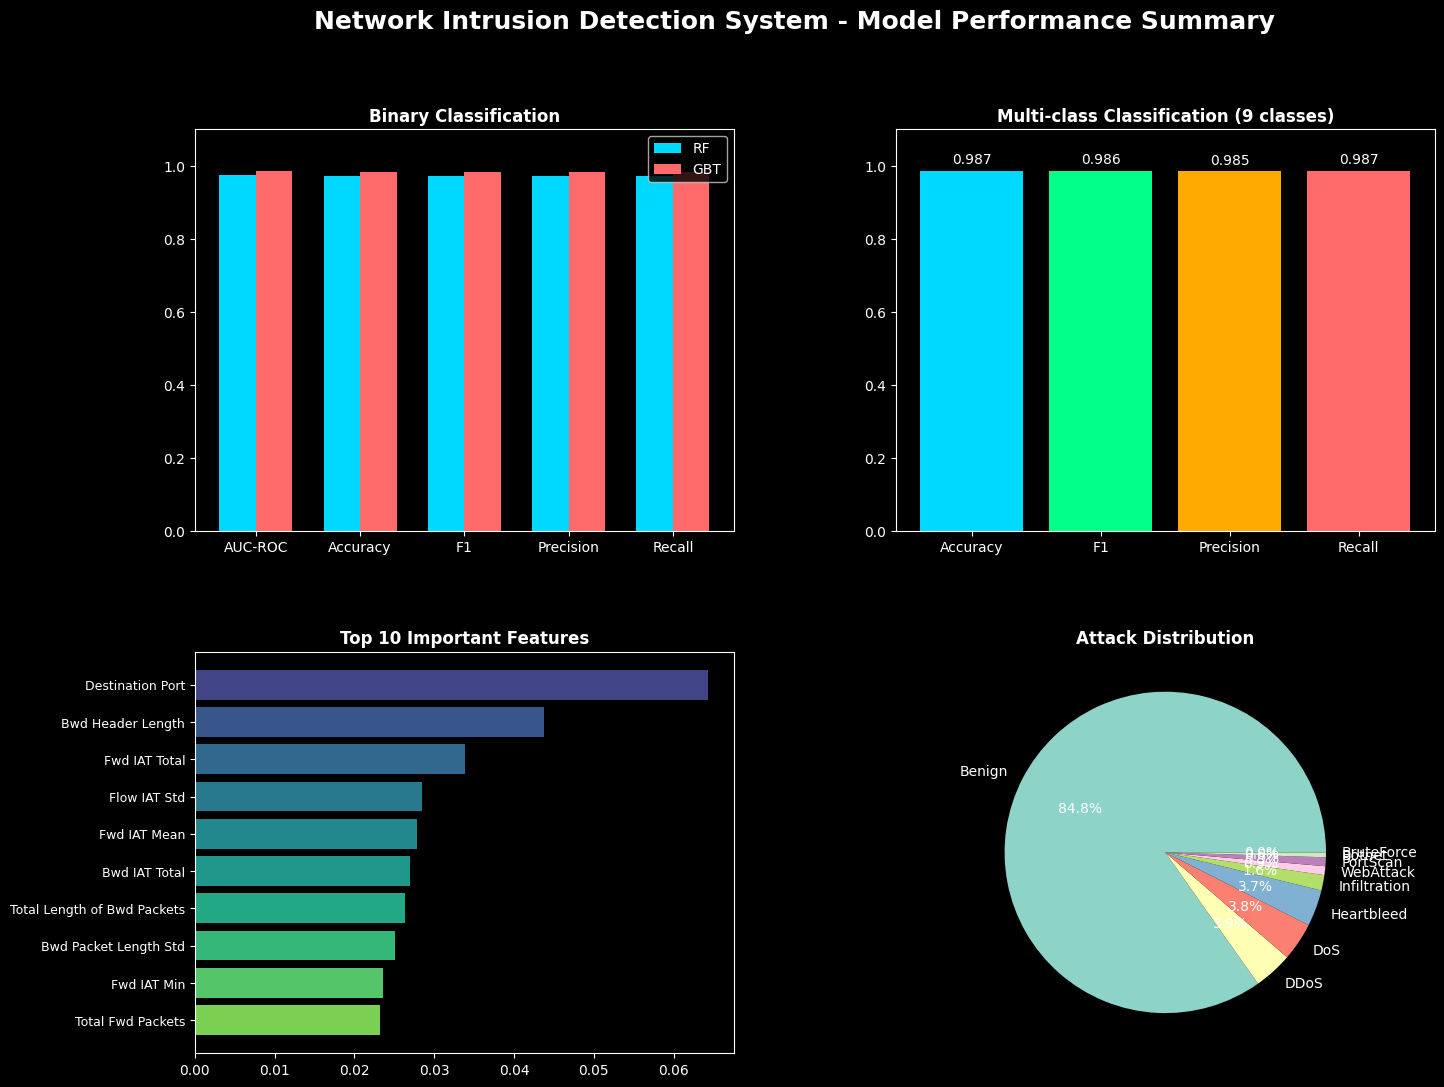


✅ Summary dashboard saved: /content/drive/MyDrive/NetworkIDS/output/visualizations/model_summary_dashboard.png


In [26]:
# Create summary dashboard
fig = plt.figure(figsize=(16, 12))

# Title
fig.suptitle('Network Intrusion Detection System - Model Performance Summary',
             fontsize=18, fontweight='bold', y=0.98)

# Layout: 2x2 grid
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Binary Model Comparison
ax1 = fig.add_subplot(gs[0, 0])
metrics = ['AUC-ROC', 'Accuracy', 'F1', 'Precision', 'Recall']
x = np.arange(len(metrics))
width = 0.35
rf_vals = [rf_binary.get('auc_roc', 0), rf_binary.get('accuracy', 0), rf_binary.get('f1', 0),
           rf_binary.get('precision', 0), rf_binary.get('recall', 0)]
gbt_vals = [gbt_binary.get('auc_roc', 0), gbt_binary.get('accuracy', 0), gbt_binary.get('f1', 0),
            gbt_binary.get('precision', 0), gbt_binary.get('recall', 0)]
ax1.bar(x - width/2, rf_vals, width, label='RF', color='#00d9ff')
ax1.bar(x + width/2, gbt_vals, width, label='GBT', color='#ff6b6b')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.set_ylim(0, 1.1)
ax1.set_title('Binary Classification', fontweight='bold')
ax1.legend()

# 2. Multi-class Metrics
ax2 = fig.add_subplot(gs[0, 1])
multi_metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
multi_vals = [rf_multi.get('accuracy', 0), rf_multi.get('f1', 0),
              rf_multi.get('precision', 0), rf_multi.get('recall', 0)]
colors = ['#00d9ff', '#00ff88', '#ffaa00', '#ff6b6b']
bars = ax2.bar(multi_metrics, multi_vals, color=colors)
ax2.set_ylim(0, 1.1)
ax2.set_title('Multi-class Classification (9 classes)', fontweight='bold')
for bar, val in zip(bars, multi_vals):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', ha='center')

# 3. Top Features
ax3 = fig.add_subplot(gs[1, 0])
top10 = feature_imp_df.head(10)
ax3.barh(range(len(top10)), top10['importance'], color=plt.cm.viridis(np.linspace(0.2, 0.8, 10)))
ax3.set_yticks(range(len(top10)))
ax3.set_yticklabels(top10['feature'], fontsize=9)
ax3.invert_yaxis()
ax3.set_title('Top 10 Important Features', fontweight='bold')

# 4. Attack Distribution
ax4 = fig.add_subplot(gs[1, 1])
ax4.pie(attack_dist['count'], labels=attack_dist['attack_type'], autopct='%1.1f%%',
        colors=plt.cm.Set3(np.linspace(0, 1, len(attack_dist))))
ax4.set_title('Attack Distribution', fontweight='bold')

plt.savefig(f"{VIZ_DIR}/model_summary_dashboard.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"\n✅ Summary dashboard saved: {VIZ_DIR}/model_summary_dashboard.png")

In [27]:
# Cleanup
test_sampled.unpersist()
spark.stop()
gc.collect()

print("\n" + "="*60)
print("✅ VISUALIZATION COMPLETE!")
print("="*60)
print(f"\nAll visualizations saved to: {VIZ_DIR}")
print("\nFiles created:")
for f in os.listdir(VIZ_DIR):
    if f.endswith('.png'):
        print(f"  📊 {f}")


✅ VISUALIZATION COMPLETE!

All visualizations saved to: /content/drive/MyDrive/NetworkIDS/output/visualizations

Files created:
  📊 model_comparison.png
  📊 confusion_matrix_multiclass.png
  📊 feature_importance.png
  📊 attack_distribution.png
  📊 per_class_recall.png
  📊 model_summary_dashboard.png
